# Runtime Data Analysis

This notebook provides a flexible, generic data analysis framework for processing runtime metrics and performance data.

## Features
- Load data from CSV or JSON files individually or in bulk
- Flexible label extraction for organizing datasets
- Comprehensive statistical analysis (mean, std, percentiles, etc.)
- Multiple visualization options (histograms, KDE, box plots, bar charts)
- Easy to extend for new metrics or data types
- Export summaries to CSV

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Union, Optional
import json
import re

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

class DataAnalyzer:
    """
    Generic data analyzer for runtime metrics and other performance data.
    Easily extensible for different metrics and file formats.
    """
    
    def __init__(self):
        self.data = {}
        self.metadata = {}
    
    def load_files(self, 
                   file_paths: Union[str, List[str]], 
                   dataset_name: Optional[str] = None,
                   label_extractor: Optional[callable] = None) -> None:
        """
        Load data from one or more files.
        
        Args:
            file_paths: Single file path or list of file paths
            dataset_name: Name for this dataset (optional, will use filename if not provided)
            label_extractor: Optional function to extract label from filename (used when loading multiple files)
        """
        if isinstance(file_paths, str):
            file_paths = [file_paths]
        
        for file_path in file_paths:
            path = Path(file_path)
            
            if not path.exists():
                print(f"Warning: {file_path} not found, skipping...")
                continue
            
            # Extract label from filename
            if label_extractor:
                label = label_extractor(path)
            elif dataset_name:
                label = dataset_name
            else:
                label = path.stem
            
            # Load data based on file extension
            if path.suffix == '.csv':
                df = pd.read_csv(file_path)
            elif path.suffix == '.json':
                with open(file_path, 'r') as f:
                    json_data = json.load(f)
                df = pd.DataFrame(json_data)
            elif path.suffix == '.jsonl':
                # Read JSONL (one JSON object per line)
                df = pd.read_json(file_path, lines=True)
            else:
                print(f"Warning: Unsupported file type {path.suffix}")
                continue
            
            self.data[label] = df
            self.metadata[label] = {
                'file_path': str(file_path),
                'num_samples': len(df),
                'columns': list(df.columns)
            }
            
            print(f"Loaded {len(df)} samples from {path.name} with columns: {list(df.columns)}")
    
    def load_pattern(self, 
                     pattern: str, 
                     label_extractor: Optional[callable] = None) -> None:
        """
        Load all files matching a glob pattern.
        
        Args:
            pattern: Glob pattern (e.g., 'experiments/logs/*.csv')
            label_extractor: Optional function to extract label from filename
        """
        files = list(Path('.').glob(pattern))
        if not files:
            print(f"No files found matching pattern: {pattern}")
            return
        
        file_paths = [str(f) for f in files]
        self.load_files(file_paths, label_extractor=label_extractor)
    
    def add_throughput_column(self,
                              latency_column='latency_ms',
                              batch_size=8,
                              seq_len=128,
                              throughput_column='throughput',
                              datasets=None):
        """
        Add a throughput column to the dataframes.
        
        Throughput = (batch_size * seq_len) / (latency_ms / 1000)
        
        Args:
            latency_column: Column name containing latency data in milliseconds
            batch_size: Batch size used in experiment
            seq_len: Sequence length (number of tokens per sequence)
            throughput_column: Name for the new throughput column
            datasets: List of datasets to process (None = all)
        """
        if datasets is None:
            datasets = list(self.data.keys())
        
        tokens_per_batch = batch_size * seq_len
        
        for dataset_name in datasets:
            df = self.data[dataset_name]
            
            if latency_column not in df.columns:
                print(f"Warning: Column '{latency_column}' not found in dataset '{dataset_name}', skipping...")
                continue
            
            # Convert latency from ms to seconds and compute throughput
            latency_seconds = df[latency_column] / 1000.0
            df[throughput_column] = tokens_per_batch / latency_seconds
            
            # Update metadata to include new column
            self.metadata[dataset_name]['columns'] = list(df.columns)
            
            print(f"Added '{throughput_column}' column to dataset '{dataset_name}'")
        
        print(f"\nThroughput computed with: batch_size={batch_size}, seq_len={seq_len}, tokens_per_batch={tokens_per_batch}")
    
    def compute_statistics(self, column: str, datasets: Optional[List[str]] = None, percentiles: List[float] = [50, 90, 95, 99]) -> pd.DataFrame:
        """
        Compute comprehensive statistics for all loaded datasets.
        
        Args:
            column: Column name to analyze
            datasets: List of dataset names to include (None = all)
            percentiles: List of percentiles to compute
            
        Returns:
            DataFrame with statistics for each dataset
        """
        if datasets is None:
            datasets = list(self.data.keys())
            
        stats_list = []
        
        for label in datasets:
            df = self.data[label]
            
            if column not in df.columns:
                print(f"Warning: Column '{column}' not found in dataset '{label}', skipping...")
                continue
                
            values = df[column]
            
            stats = {
                'dataset': label,
                'column': column,
                'count': len(values),
                'mean': values.mean(),
                'std': values.std(),
                'min': values.min(),
                'max': values.max(),
            }
            
            # Add percentiles
            for p in percentiles:
                stats[f'p{p}'] = values.quantile(p/100)
            
            stats_list.append(stats)
        
        return pd.DataFrame(stats_list)
    
    def plot_distributions(self, 
                          column: str,
                          datasets: Optional[List[str]] = None,
                          plot_type: str = 'hist',
                          bins: int = 50,
                          figsize: tuple = (14, 6)) -> None:
        """
        Plot distributions of metrics.
        
        Args:
            column: Column name to analyze
            datasets: List of dataset labels to plot (None = all)
            plot_type: 'hist', 'kde', or 'both'
            bins: Number of bins for histogram
            figsize: Figure size
        """
        if datasets is None:
            datasets = list(self.data.keys())
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        for label in datasets:
            df = self.data[label]
            
            if column not in df.columns:
                print(f"Warning: Column '{column}' not found in dataset '{label}', skipping...")
                continue
                
            values = df[column]
            
            # Histogram
            if plot_type in ['hist', 'both']:
                axes[0].hist(values, bins=bins, alpha=0.6, label=label)
            
            # KDE
            if plot_type in ['kde', 'both']:
                values.plot.kde(ax=axes[1], label=label)
        
        axes[0].set_xlabel(f'{column}')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('Distribution (Histogram)')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        axes[1].set_xlabel(f'{column}')
        axes[1].set_ylabel('Density')
        axes[1].set_title('Distribution (KDE)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_comparison(self,
                       dataset: str,
                       column: str,
                       metrics: List[str] = ['mean', 'median', 'p95', 'p99'],
                       figsize: tuple = (10, 6)) -> None:
        """
        Bar plot comparing multiple metrics for a single dataset and column.

        Args:
            dataset: Dataset label to analyze
            column: Column name to analyze
            metrics: List of metrics to compare ('mean', 'median', 'p95', etc.)
            figsize: Figure size
        """
        if dataset not in self.data:
            print(f"Error: Dataset '{dataset}' not found")
            print(f"Available datasets: {self.list_datasets()}")
            return

        df = self.data[dataset]
        
        if column not in df.columns:
            print(f"Error: Column '{column}' not found in dataset '{dataset}'")
            print(f"Available columns: {list(df.columns)}")
            return
            
        data = df[column]

        values = []
        labels = []

        for metric in metrics:
            if metric == 'mean':
                val = data.mean()
            elif metric == 'median':
                val = data.median()
            elif metric.startswith('p'):
                percentile = int(metric[1:])
                val = data.quantile(percentile/100)
            elif metric in ['min', 'max', 'std']:
                val = getattr(data, metric)()
            else:
                print(f"Warning: Unknown metric '{metric}', skipping")
                continue

            values.append(val)
            labels.append(metric.upper())

        plt.figure(figsize=figsize)
        plt.bar(labels, values)
        plt.xlabel('Metric')
        plt.ylabel(f'{column}')
        plt.title(f'Metric Comparison for {dataset} - {column}')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    
    def plot_boxplot(self, 
                     column: str,
                     datasets: Optional[List[str]] = None,
                     figsize: tuple = (12, 6)) -> None:
        """
        Create box plot for comparing distributions.
        
        Args:
            column: Column name to analyze
            datasets: List of dataset labels to plot (None = all)
            figsize: Figure size
        """
        if datasets is None:
            datasets = list(self.data.keys())
        
        plot_data = []
        plot_labels = []
        
        for label in datasets:
            df = self.data[label]
            
            if column not in df.columns:
                print(f"Warning: Column '{column}' not found in dataset '{label}', skipping...")
                continue
                
            plot_data.append(df[column].values)
            plot_labels.append(label)
        
        plt.figure(figsize=figsize)
        plt.boxplot(plot_data, labels=plot_labels)
        plt.xlabel('Dataset')
        plt.ylabel(f'{column}')
        plt.title(f'Distribution Comparison (Box Plot) - {column}')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    
    def export_summary(self, column: str, output_file: str, datasets: Optional[List[str]] = None, percentiles: List[float] = [50, 90, 95, 99]) -> None:
        """
        Export summary statistics to CSV.
        
        Args:
            column: Column name to analyze
            output_file: Path to output CSV file
            datasets: List of dataset names to include (None = all)
            percentiles: List of percentiles to include
        """
        stats_df = self.compute_statistics(column, datasets, percentiles)
        stats_df.to_csv(output_file, index=False)
        print(f"Summary exported to {output_file}")
    
    def get_data(self, label: str) -> pd.DataFrame:
        """Get raw data for a specific dataset."""
        return self.data.get(label)
    
    def list_datasets(self) -> List[str]:
        """List all loaded datasets."""
        return list(self.data.keys())
    
    def get_columns(self, dataset: str) -> List[str]:
        """Get list of columns for a specific dataset."""
        if dataset in self.metadata:
            return self.metadata[dataset]['columns']
        return []
    
    def clear(self) -> None:
        """Clear all loaded data."""
        self.data.clear()
        self.metadata.clear()

# Helper functions for common label extraction patterns
def extract_batch_size(filename: str) -> str:
    """Extract batch size from filename like 'model_b8_L128_latencies_ms.csv'"""
    match = re.search(r'_b(\d+)_', filename)
    return f"batch_{match.group(1)}" if match else filename

def extract_model_and_batch(filename: str) -> str:
    """Extract model and batch size from filename"""
    model_match = re.search(r'(distilgpt2|Mistral)', filename)
    batch_match = re.search(r'_b(\d+)_', filename)
    
    model = model_match.group(1) if model_match else "unknown"
    batch = batch_match.group(1) if batch_match else "unknown"
    
    return f"{model}_b{batch}"

print("DataAnalyzer class loaded successfully!")
print("\nQuick start examples:")
print("  analyzer = DataAnalyzer()")
print("  analyzer.load_files('path/to/file.csv', dataset_name='experiment1')")
print("  analyzer.load_pattern('experiments/logs/*.csv', label_extractor=extract_batch_size)")
print("  stats = analyzer.compute_statistics(column='latency_ms')")
print("  analyzer.plot_distributions(column='latency_ms')")
print("  analyzer.plot_comparison(dataset='experiment1', column='latency_ms', metrics=['mean', 'p95', 'p99'])")

DataAnalyzer class loaded successfully!

Quick start examples:
  analyzer = DataAnalyzer()
  analyzer.load_files('path/to/file.csv', dataset_name='experiment1')
  analyzer.load_pattern('experiments/logs/*.csv', label_extractor=extract_batch_size)
  stats = analyzer.compute_statistics(column='latency_ms')
  analyzer.plot_distributions(column='latency_ms')
  analyzer.plot_comparison(dataset='experiment1', column='latency_ms', metrics=['mean', 'p95', 'p99'])


In [77]:
# Add method to DataAnalyzer for computing total throughput
def compute_total_throughput(analyzer,
                              latency_column='latency_ms',
                              batch_size=8,
                              seq_len=128,
                              datasets=None):
    """
    Compute total throughput for multi-tenant experiments.
    
    For multi-tenant scenarios, the total throughput is the sum of individual
    model throughputs. This allows comparison between:
    - Single model on 1 GPU
    - Multiple models sharing 1 GPU
    
    Args:
        analyzer: DataAnalyzer instance
        latency_column: Column name containing latency data in milliseconds
        batch_size: Batch size used in experiment
        seq_len: Sequence length (number of tokens per sequence)
        datasets: List of datasets to include (None = all)
    
    Returns:
        DataFrame with per-iteration total throughput and statistics
    """
    if datasets is None:
        datasets = analyzer.list_datasets()
    
    tokens_per_batch = batch_size * seq_len
    
    # Collect all throughput data aligned by iteration
    throughput_by_iter = {}
    
    for dataset_name in datasets:
        df = analyzer.get_data(dataset_name)
        
        if df is None:
            print(f"Warning: Dataset '{dataset_name}' not found, skipping...")
            continue
        
        if latency_column not in df.columns:
            print(f"Warning: Column '{latency_column}' not found in dataset '{dataset_name}', skipping...")
            continue
        
        # Compute throughput for each iteration
        for idx, row in df.iterrows():
            iter_num = row.get('iter', idx)
            latency_ms = row[latency_column]
            throughput = tokens_per_batch / (latency_ms / 1000.0)
            
            if iter_num not in throughput_by_iter:
                throughput_by_iter[iter_num] = []
            throughput_by_iter[iter_num].append(throughput)
    
    # Sum throughputs for each iteration
    total_throughput_data = []
    for iter_num in sorted(throughput_by_iter.keys()):
        total_throughput = sum(throughput_by_iter[iter_num])
        total_throughput_data.append({
            'iter': iter_num,
            'total_throughput': total_throughput,
            'num_models': len(throughput_by_iter[iter_num])
        })
    
    result_df = pd.DataFrame(total_throughput_data)
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print(f"TOTAL THROUGHPUT ANALYSIS")
    print(f"{'='*60}")
    print(f"Configuration: {len(datasets)} models on 1 GPU")
    print(f"Batch size: {batch_size}, Seq length: {seq_len}")
    print(f"Tokens per batch: {tokens_per_batch}")
    print(f"\nTotal Throughput Statistics (tokens/second):")
    print(f"  Mean:   {result_df['total_throughput'].mean():,.2f}")
    print(f"  Std:    {result_df['total_throughput'].std():,.2f}")
    print(f"  Min:    {result_df['total_throughput'].min():,.2f}")
    print(f"  Max:    {result_df['total_throughput'].max():,.2f}")
    print(f"  Median: {result_df['total_throughput'].median():,.2f}")
    print(f"  P95:    {result_df['total_throughput'].quantile(0.95):,.2f}")
    print(f"  P99:    {result_df['total_throughput'].quantile(0.99):,.2f}")
    print(f"{'='*60}\n")
    
    return result_df


def compare_multi_vs_single_tenant(multi_tenant_analyzer, 
                                    single_tenant_analyzer,
                                    batch_size=8,
                                    seq_len=128,
                                    figsize=(14, 6)):
    """
    Compare total throughput between multi-tenant and single-tenant configurations.
    
    Args:
        multi_tenant_analyzer: DataAnalyzer with multiple model datasets loaded
        single_tenant_analyzer: DataAnalyzer with single model dataset loaded
        batch_size: Batch size used
        seq_len: Sequence length
        figsize: Figure size for plots
    
    Returns:
        Dictionary with comparison statistics
    """
    # Compute total throughput for multi-tenant
    print("Computing multi-tenant total throughput...")
    multi_df = compute_total_throughput(multi_tenant_analyzer, 
                                       batch_size=batch_size, 
                                       seq_len=seq_len)
    
    # Compute throughput for single tenant
    print("\nComputing single-tenant throughput...")
    single_datasets = single_tenant_analyzer.list_datasets()
    if len(single_datasets) == 0:
        print("Error: No datasets in single_tenant_analyzer")
        return None
    
    single_df = single_tenant_analyzer.get_data(single_datasets[0])
    tokens_per_batch = batch_size * seq_len
    single_throughput = tokens_per_batch / (single_df['latency_ms'] / 1000.0)
    
    # Comparison statistics
    multi_mean = multi_df['total_throughput'].mean()
    single_mean = single_throughput.mean()
    improvement = ((multi_mean - single_mean) / single_mean) * 100
    
    print(f"\n{'='*60}")
    print(f"MULTI-TENANT vs SINGLE-TENANT COMPARISON")
    print(f"{'='*60}")
    print(f"Multi-tenant ({multi_df['num_models'].iloc[0]} models):")
    print(f"  Mean throughput: {multi_mean:,.2f} tokens/s")
    print(f"\nSingle-tenant (1 model):")
    print(f"  Mean throughput: {single_mean:,.2f} tokens/s")
    print(f"\nDifference: {improvement:+.2f}%")
    if improvement > 0:
        print(f"Multi-tenant provides {improvement:.2f}% MORE total throughput")
    else:
        print(f"Multi-tenant provides {abs(improvement):.2f}% LESS total throughput")
    print(f"{'='*60}\n")
    
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Distribution comparison
    axes[0].hist(multi_df['total_throughput'], bins=30, alpha=0.6, label=f'Multi-tenant ({multi_df["num_models"].iloc[0]} models)', color='blue')
    axes[0].hist(single_throughput, bins=30, alpha=0.6, label='Single-tenant (1 model)', color='orange')
    axes[0].set_xlabel('Throughput (tokens/s)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Throughput Distribution Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Bar chart of means
    means = [multi_mean, single_mean]
    labels = [f'Multi-tenant\n({multi_df["num_models"].iloc[0]} models)', 'Single-tenant\n(1 model)']
    colors = ['blue', 'orange']
    
    bars = axes[1].bar(labels, means, color=colors, alpha=0.6)
    axes[1].set_ylabel('Mean Throughput (tokens/s)')
    axes[1].set_title('Mean Throughput Comparison')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:,.0f}',
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'multi_tenant_mean': multi_mean,
        'single_tenant_mean': single_mean,
        'improvement_percent': improvement,
        'multi_df': multi_df,
        'single_throughput': single_throughput
    }


print("Total throughput analysis functions loaded!")
print("\nUsage examples:")
print("  # Compute total throughput for multi-tenant setup")
print("  total_throughput_df = compute_total_throughput(analyzer, batch_size=8, seq_len=128)")
print("")
print("  # Compare multi-tenant vs single-tenant")
print("  comparison = compare_multi_vs_single_tenant(multi_analyzer, single_analyzer, batch_size=8, seq_len=128)")


Total throughput analysis functions loaded!

Usage examples:
  # Compute total throughput for multi-tenant setup
  total_throughput_df = compute_total_throughput(analyzer, batch_size=8, seq_len=128)

  # Compare multi-tenant vs single-tenant
  comparison = compare_multi_vs_single_tenant(multi_analyzer, single_analyzer, batch_size=8, seq_len=128)


In [78]:
# Create analyzer instance
triple_analyzer = DataAnalyzer()

# Load specific files
#analyzing 3 model experiment
files_pattern_to_analyze = '../data/3_distilgpt2_mps/**/events.jsonl'

# Load with custom labels
triple_analyzer.load_pattern(files_pattern_to_analyze, 
                   label_extractor=lambda name: name.parent.name)


# Compute and display statistics
stats = triple_analyzer.compute_statistics(column='latency_ms', percentiles=[50, 90, 95, 99])
print(stats.to_string())
print(triple_analyzer.data)

Loaded 100 samples from events.jsonl with columns: ['type', 'iter', 'latency_ms']
Loaded 100 samples from events.jsonl with columns: ['type', 'iter', 'latency_ms']
Loaded 100 samples from events.jsonl with columns: ['type', 'iter', 'latency_ms']
        dataset      column  count       mean       std        min        max        p50        p90        p95        p99
0  distilgpt2_1  latency_ms    100  35.121459  0.423181  34.320385  37.904385  35.042303  35.578062  35.622604  35.758254
1  distilgpt2_2  latency_ms    100  36.578120  0.276215  36.063232  37.176319  36.547071  37.001422  37.020161  37.099274
2  distilgpt2_3  latency_ms    100  34.468065  0.220383  33.986561  34.946049  34.475008  34.754765  34.790655  34.894348
{'distilgpt2_1':          type  iter  latency_ms
0   iteration     0   37.904385
1   iteration     1   35.454975
2   iteration     2   35.507198
3   iteration     3   35.542015
4   iteration     4   35.312641
..        ...   ...         ...
95  iteration    95   35.

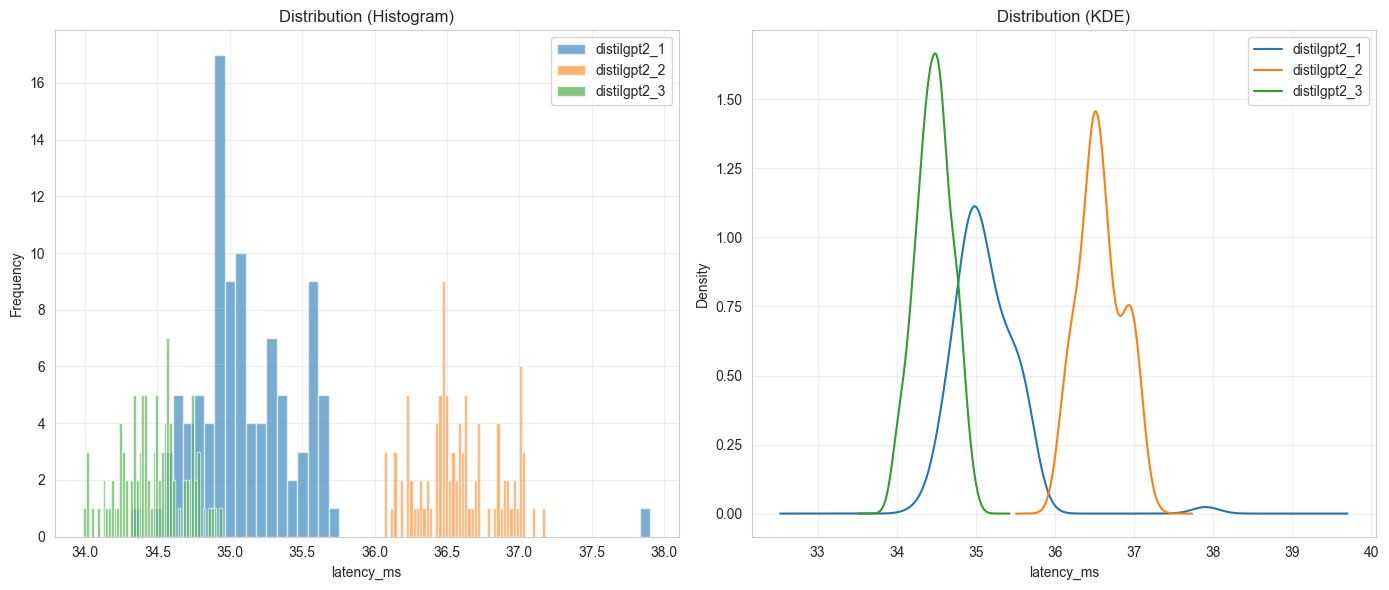

In [79]:
# Plot distributions (histogram and KDE)
triple_analyzer.plot_distributions(column='latency_ms', plot_type='both', bins=50)


## Example 4: Compare Metrics Across Datasets

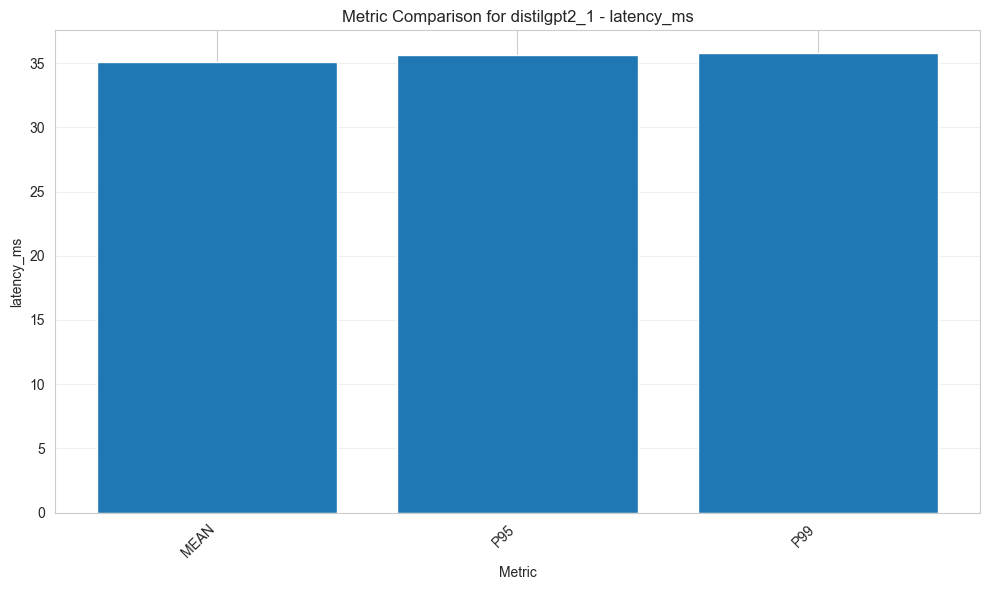

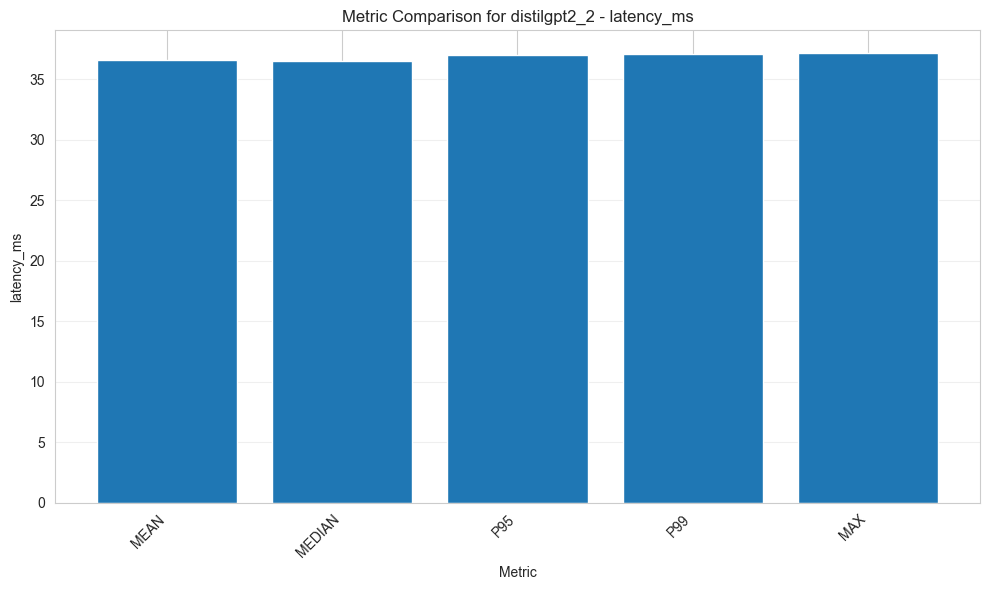

In [80]:
# Compare mean latencies
triple_analyzer.plot_comparison(dataset='distilgpt2_1', column='latency_ms', metrics=['mean', 'p95', 'p99'])

# Compare p95 latencies
triple_analyzer.plot_comparison(dataset='distilgpt2_2', column='latency_ms', metrics=['mean', 'median', 'p95', 'p99', 'max'])


## Example 5: Box Plot Comparison

/var/folders/pm/gwsfskks48j0z9y1sqy1xs640000gn/T/ipykernel_20419/2192335433.py:320: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=plot_labels)


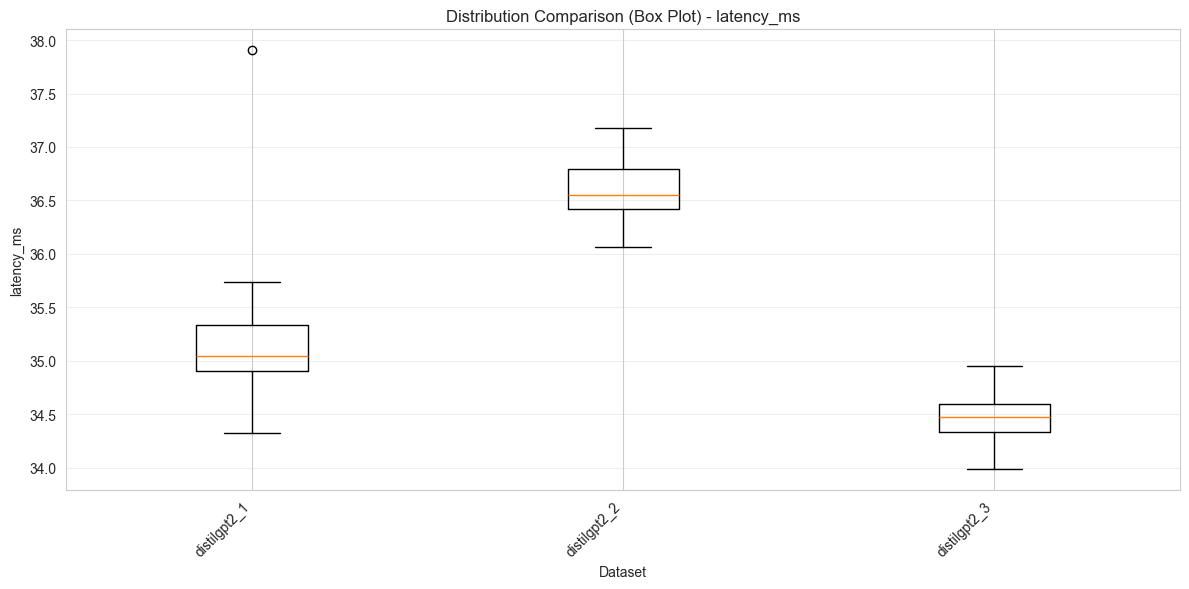

In [81]:
# Box plot for distribution comparison
triple_analyzer.plot_boxplot(column='latency_ms')


Added 'throughput' column to dataset 'distilgpt2_1'
Added 'throughput' column to dataset 'distilgpt2_2'
Added 'throughput' column to dataset 'distilgpt2_3'

Throughput computed with: batch_size=8, seq_len=128, tokens_per_batch=1024


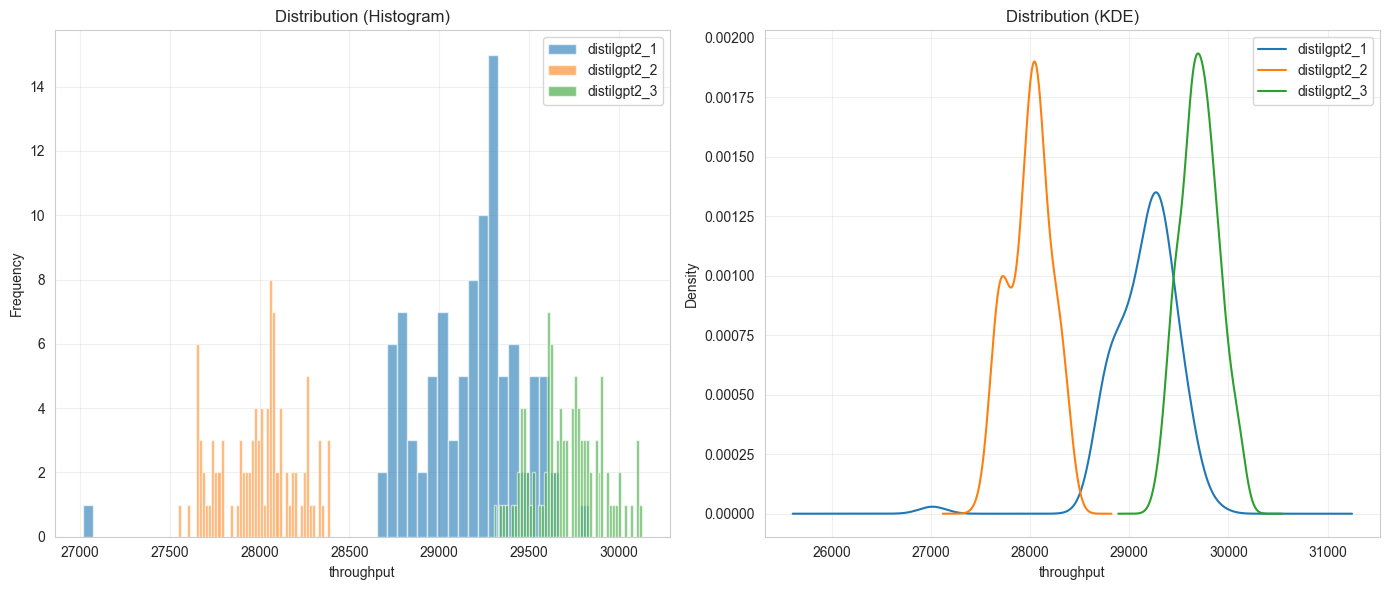

In [82]:
#Caclulate throughput
triple_analyzer.add_throughput_column(latency_column='latency_ms', 
                      batch_size=8, 
                      seq_len=128)

triple_analyzer.plot_distributions(column='throughput', plot_type='both', bins=50)

Analyze single distilgpt2 on gpu

Loaded 100 samples from events.jsonl with columns: ['type', 'iter', 'latency_ms']


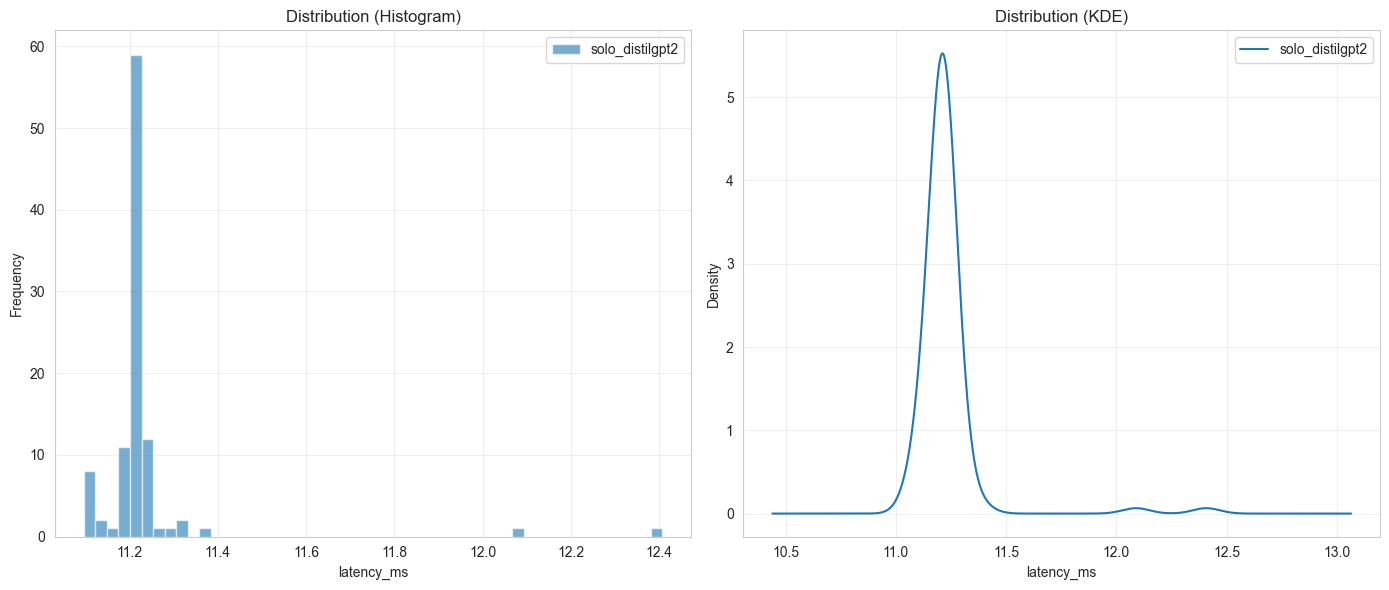

Added 'throughput' column to dataset 'solo_distilgpt2'

Throughput computed with: batch_size=8, seq_len=128, tokens_per_batch=1024


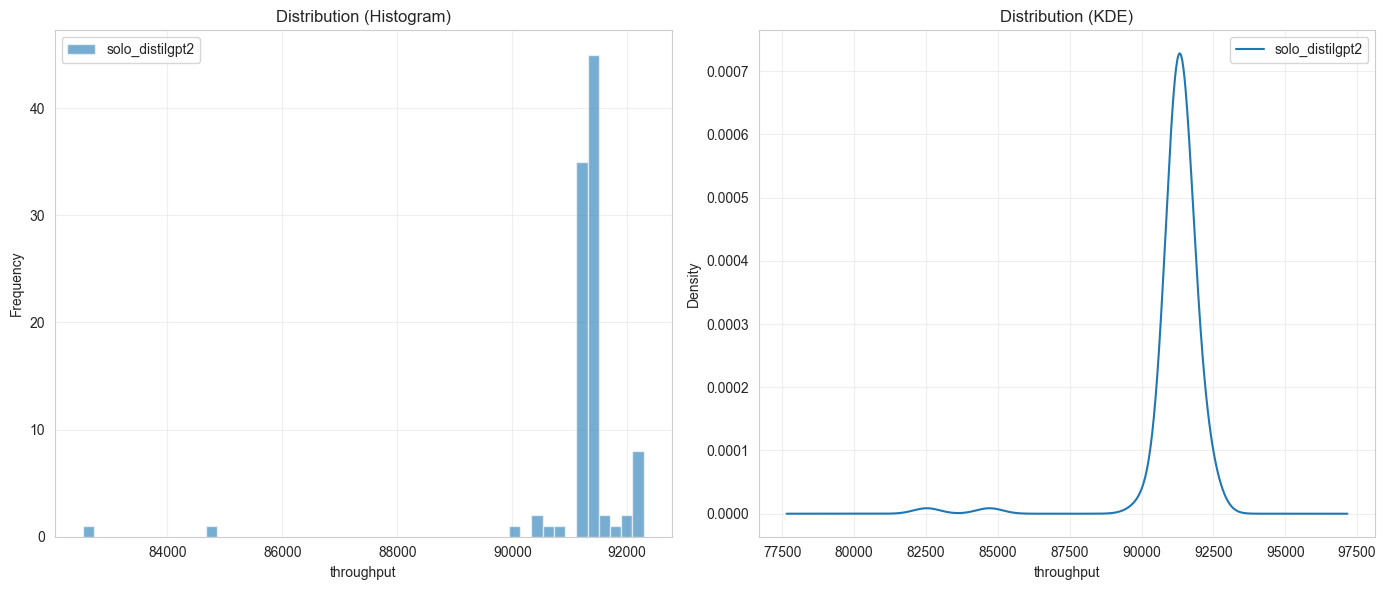

Loaded 100 samples from events.jsonl with columns: ['type', 'iter', 'latency_ms']
Loaded 100 samples from events.jsonl with columns: ['type', 'iter', 'latency_ms']
Loaded 100 samples from events.jsonl with columns: ['type', 'iter', 'latency_ms']
Loaded 100 samples from events.jsonl with columns: ['type', 'iter', 'latency_ms']
Loaded 100 samples from events.jsonl with columns: ['type', 'iter', 'latency_ms']
Loaded 100 samples from events.jsonl with columns: ['type', 'iter', 'latency_ms']
Computing multi-tenant total throughput...

TOTAL THROUGHPUT ANALYSIS
Configuration: 4 models on 1 GPU
Batch size: 8, Seq length: 128
Tokens per batch: 1024

Total Throughput Statistics (tokens/second):
  Mean:   84,232.21
  Std:    493.67
  Min:    83,006.12
  Max:    85,414.18
  Median: 84,230.64
  P95:    85,019.94
  P99:    85,361.83


Computing single-tenant throughput...

MULTI-TENANT vs SINGLE-TENANT COMPARISON
Multi-tenant (4 models):
  Mean throughput: 84,232.21 tokens/s

Single-tenant (1 model

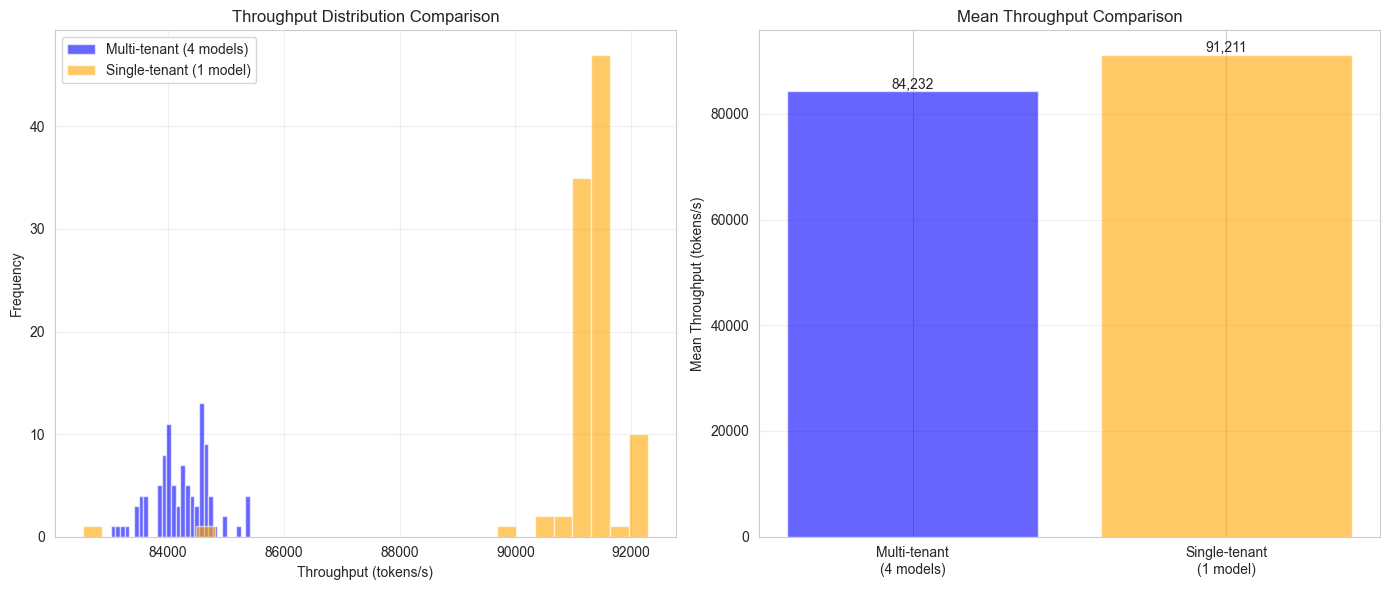

Computing multi-tenant total throughput...

TOTAL THROUGHPUT ANALYSIS
Configuration: 3 models on 1 GPU
Batch size: 8, Seq length: 128
Tokens per batch: 1024

Total Throughput Statistics (tokens/second):
  Mean:   86,866.34
  Std:    693.84
  Min:    84,376.69
  Max:    88,351.76
  Median: 86,950.81
  P95:    87,986.18
  P99:    88,138.20


Computing single-tenant throughput...

MULTI-TENANT vs SINGLE-TENANT COMPARISON
Multi-tenant (3 models):
  Mean throughput: 86,866.34 tokens/s

Single-tenant (1 model):
  Mean throughput: 91,210.69 tokens/s

Difference: -4.76%
Multi-tenant provides 4.76% LESS total throughput



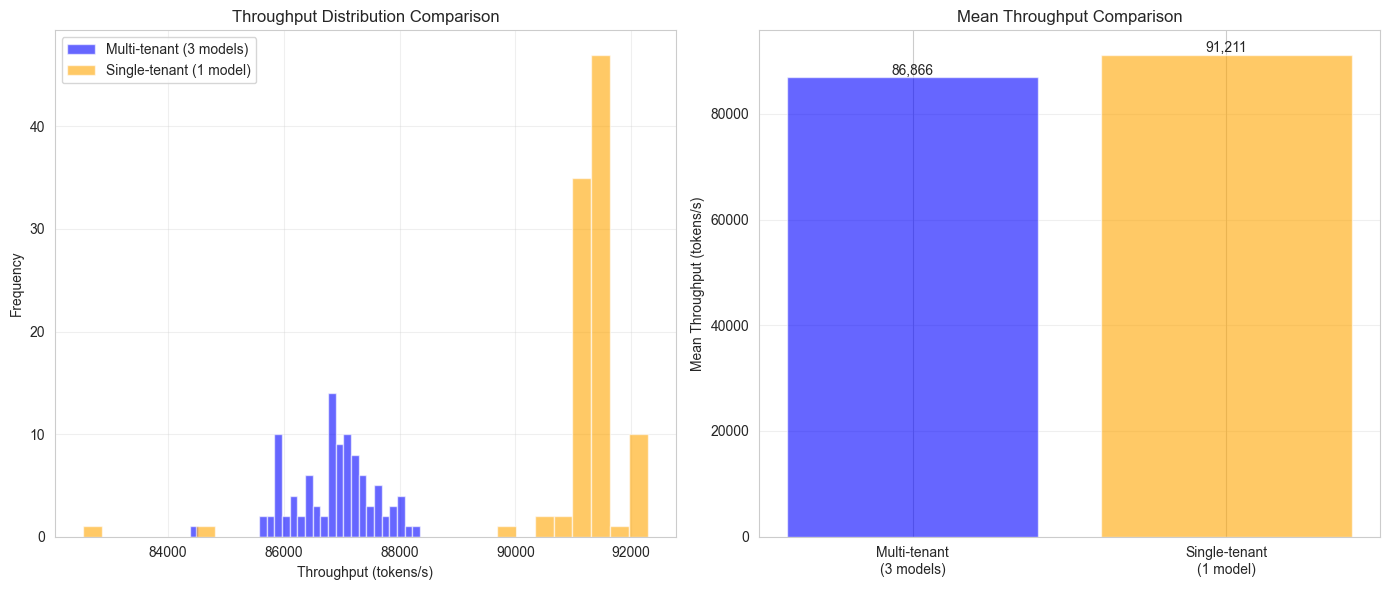

Computing multi-tenant total throughput...

TOTAL THROUGHPUT ANALYSIS
Configuration: 2 models on 1 GPU
Batch size: 8, Seq length: 128
Tokens per batch: 1024

Total Throughput Statistics (tokens/second):
  Mean:   90,015.05
  Std:    2,389.42
  Min:    81,292.69
  Max:    92,808.66
  Median: 90,646.15
  P95:    91,783.80
  P99:    92,268.68


Computing single-tenant throughput...

MULTI-TENANT vs SINGLE-TENANT COMPARISON
Multi-tenant (2 models):
  Mean throughput: 90,015.05 tokens/s

Single-tenant (1 model):
  Mean throughput: 91,210.69 tokens/s

Difference: -1.31%
Multi-tenant provides 1.31% LESS total throughput



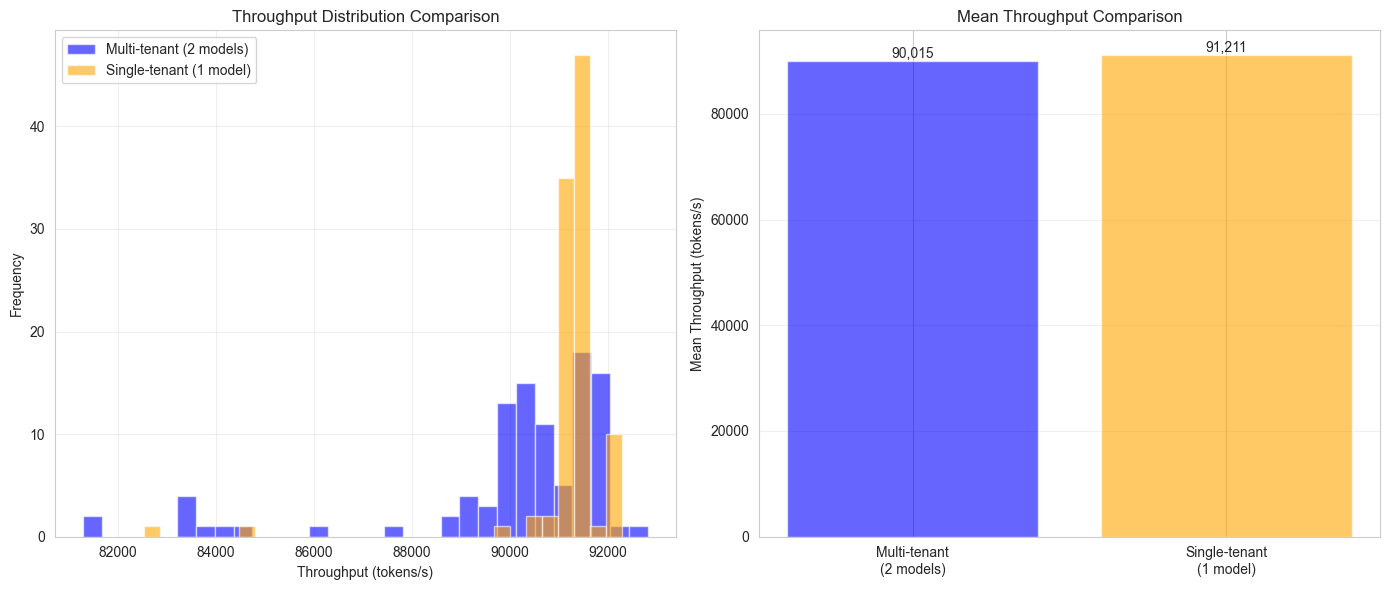

{'multi_tenant_mean': 90015.04638865594,
 'single_tenant_mean': 91210.6863585719,
 'improvement_percent': -1.3108551395124841,
 'multi_df':     iter  total_throughput  num_models
 0      0      81292.685305           2
 1      1      85918.615557           2
 2      2      91344.236006           2
 3      3      90290.493759           2
 4      4      90410.184709           2
 ..   ...               ...         ...
 95    95      90659.586004           2
 96    96      89114.670195           2
 97    97      89953.096746           2
 98    98      89178.132890           2
 99    99      92263.220939           2
 
 [100 rows x 3 columns],
 'single_throughput': 0     90383.221379
 1     82528.676695
 2     91249.198849
 3     91224.228184
 4     91307.527284
           ...     
 95    91324.200702
 96    91166.013832
 97    91240.878944
 98    91827.368193
 99    92199.887960
 Name: latency_ms, Length: 100, dtype: float64}

In [88]:

from tokenize import Double


single_analyzer = DataAnalyzer()

single_analyzer.load_files(
    '../data/solo_distilgpt2_b8_128/distilgpt2/events.jsonl',
    dataset_name='solo_distilgpt2'
)

single_analyzer.plot_distributions(column='latency_ms', plot_type='both', bins=50)

single_analyzer.add_throughput_column(latency_column='latency_ms', 
                      batch_size=8, 
                      seq_len=128)

single_analyzer.plot_distributions(column='throughput', plot_type='both', bins=50)

double_analyzer = DataAnalyzer()

files_pattern_to_analyze = '../data/pair_distilgpt2/**/events.jsonl'

double_analyzer.load_pattern(files_pattern_to_analyze, 
                   label_extractor=lambda name: name.parent.name)

quad_analyzer = DataAnalyzer()

files_pattern_to_analyze = '../data/4_distilgpt2_mps/**/events.jsonl'

quad_analyzer.load_pattern(files_pattern_to_analyze, 
                   label_extractor=lambda name: name.parent.name)

compare_multi_vs_single_tenant(quad_analyzer, single_analyzer, batch_size=8, seq_len=128)

compare_multi_vs_single_tenant(triple_analyzer, single_analyzer, batch_size=8, seq_len=128)

compare_multi_vs_single_tenant(double_analyzer, single_analyzer, batch_size=8, seq_len=128)
